На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [128]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [129]:
df = pd.read_excel('AB_Test_Results.xlsx')


In [130]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [132]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [133]:
df.shape

(10000, 3)

In [134]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [135]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [136]:
df.USER_ID.nunique()

6324

In [137]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.00
1,3,control,0.00
2,3,variant,0.00
3,4,variant,0.00
4,5,variant,0.00
...,...,...,...
7860,9996,control,0.00
7861,9996,variant,6.46
7862,9998,control,0.00
7863,10000,control,0.00


In [138]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    3934
control    3931
Name: count, dtype: int64

In [139]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})



In [140]:
more_than_one_types = v.query('VARIANT_NAME > 1')
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [141]:
df_new.shape

(4783, 3)

In [142]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [143]:
len(control)


2390

In [144]:
len(test)

2393

In [149]:
df_new.query('VARIANT_NAME == "control"').REVENUE.sum()

470.56

In [154]:
df_new.query('VARIANT_NAME == "variant"').REVENUE.sum()

179.32

In [155]:
# проверка на нормальность. Т.к. выборка менее 5000 используем тест Шапиро-Уилка
alpha = 0.05

st = shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));


Distribution is not normal



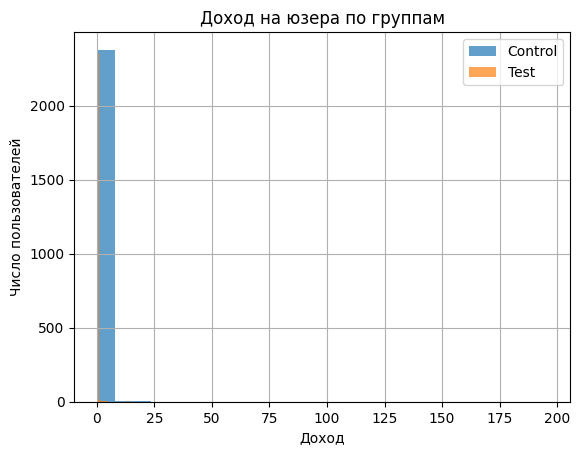

In [156]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

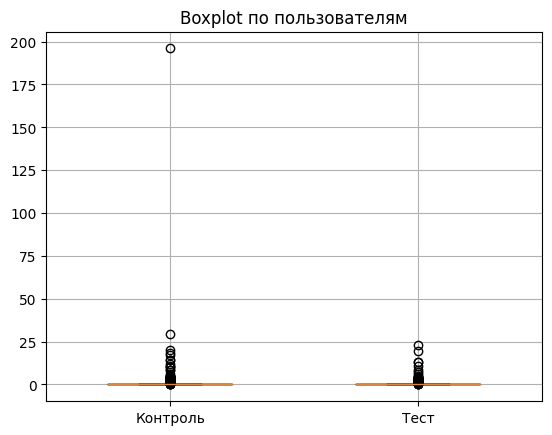

In [157]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [158]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

Статистически значимые различия между группами отсутствуют. Возможно некорректно проведено сплитование. По имеющимся результатам суммарная выручка в тестовой группе значительно меньше, чем в контрольной. Изменения не выкатываем.